# Results

In [3]:
import gc
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import lightgbm as lgb
import torch
import scipy
import opendatasets as od
import math
import torchmetrics
import importlib
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import category_encoders
import glob
import yaml              
from sklearn.preprocessing import LabelEncoder  
from sklearn import metrics                     
import pytorch_tabular

import utils.mlp as mlp
import utils.mlp_pipeline as mlp_pipeline
import utils.embedding_pipeline as embedding_pipeline
from rtdl.rtdl import data as data
import utils.tabtransformer as tabtransformer


C:\Users\ritas\anaconda3\lib\site-packages\pytorch_tabular\models\mixture_density\mdn.py:25: UserWarning: Wandb not installed. WandbLogger will not work.
  warnings.warn("Wandb not installed. WandbLogger will not work.")


In [4]:
#Functions to read pickle files

import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
        
class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        if module == "gdrive.MyDrive.rtdl.rtdl.data":
            renamed_module = "rtdl.rtdl.data"

        return super(RenameUnpickler, self).find_class(renamed_module, name)


def renamed_load(file_obj):
    return RenameUnpickler(file_obj).load()


def renamed_loads(pickled_bytes):
    file_obj = io.BytesIO(pickled_bytes)
    return renamed_load(file_obj)

# Loading the Data

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")


extension = "csv"  # or "parquet", depending on the downloaded file
data_paths = glob.glob(f"</path/to/datasets/>*.{extension}")

def read_dataset(path, ext=extension):
    if ext == "csv":
        return pd.read_csv(path, index_col=0)
    elif ext == "parquet":
        return pd.read_parquet(path)
    else:
        raise ValueError(f"Invalid extension: '{ext}'.")

def get_variant(path):
        return path.split("/")[-1].split(".")[0]

dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}


# Define path to datasets. Replace `base_path` with the appropriate value.
base_path = "bank-account-fraud-dataset-neurips-2022/"

datasets_paths = {
    "Base":    base_path + "Base.csv",
}

datasets = {key: pd.read_csv(path) for key, path in datasets_paths.items()}


# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
val_dfs = {key: df[df["month"]==6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs= {key: df[df["month"]==7].sample(frac=1, replace=False) for key, df in datasets.items()}

label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]


for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    val=val_dfs[name]
    test = test_dfs[name]
    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        val[feat] = encoder.transform(val[feat])  # Transform val set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes.
    X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_train = train_dfs[dataset_name]["fraud_bool"]
    X_val = val_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_val = val_dfs[dataset_name]["fraud_bool"]
    X_test=test_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_test = test_dfs[dataset_name]["fraud_bool"]

Using cpu device


In [6]:
#Establish continuous and categorical features
cat_cols=categorical_features
cont_cols=train.columns.difference(cat_cols)
cont_cols=cont_cols.difference(['fraud_bool'])

# Result Analysis

In [1]:
#Function to calculate recall at FPR of rate

def find_optimal_recall(y_true,y_pred,rate):
    fpr,tpr,thresholds=skl.metrics.roc_curve(y_true,y_pred,drop_intermediate=False)
    optimal_index=np.argmin(abs(fpr-rate*np.ones(len(fpr))))
    return tpr[optimal_index]

# LightGBM

In [9]:
auc_lgbm=np.zeros([20])
recall_lgbm=np.zeros([20])
auc_lgbm_test=np.zeros([20])
recall_lgbm_test=np.zeros([20])
auc_lgbm_num=np.zeros([20])
recall_lgbm_num=np.zeros([20])
auc_lgbm_test_num=np.zeros([20])
recall_lgbm_test_num=np.zeros([20])

for i in range(0,20):
    link="LGBM_BAF/lgbm_{}.pkl".format(i)
    file = open(link,'rb')
    model =joblib.load(file)
    predict=model.predict_proba(X_val)[:,1]
    auc_lgbm[i]=skl.metrics.roc_auc_score(y_val,predict)
    recall_lgbm[i]=find_optimal_recall(y_val,predict,0.05)
    predict_test=model.predict_proba(X_test)[:,1]
    auc_lgbm_test[i]=skl.metrics.roc_auc_score(y_test,predict_test)
    recall_lgbm_test[i]=find_optimal_recall(y_test,predict_test,0.05)

for i in range(0,20):
    link="LGBM_BAF/lgbm_onlycontfeatures{}.pkl".format(i)
    file = open(link,'rb')
    model =joblib.load(file)
    predict=model.predict_proba(X_val[cont_cols])[:,1]
    auc_lgbm_num[i]=skl.metrics.roc_auc_score(y_val,predict)
    recall_lgbm_num[i]=find_optimal_recall(y_val,predict,0.05)
    predict_test=model.predict_proba(X_test[cont_cols])[:,1]
    auc_lgbm_test_num[i]=skl.metrics.roc_auc_score(y_test,predict_test)
    recall_lgbm_test_num[i]=find_optimal_recall(y_test,predict_test,0.05)

In [35]:
print(np.mean(auc_lgbm_test_num))
print(np.mean(auc_lgbm_test))

0.8688324391486931
0.892726896554356


In [18]:
auc_lgbm_numenc=np.zeros([4,20])
recall_lgbm_numenc=np.zeros([4,20])
link="tab_norm_folder-20230202/tab_norm_folder/encoders/numerical_encoder_dim10.pkl"
file = open(link,'rb')
encoder =renamed_load(file)
transformed_val=encoder.transform(torch.tensor(X_val[cont_cols.difference(['device_fraud_count'])].values))
X_val_aux=torch.cat([torch.tensor(X_val[cat_cols].values),transformed_val],1).float()
for i in range(0,20):
    link='LGBM_BAF/lgbm_numericalemb_label{}.pkl'.format(i)
    file = open(link,'rb')
    model =joblib.load(file)
    predict=model.predict_proba(X_val_aux)[:,1]
    auc_lgbm_numenc[0][i]=skl.metrics.roc_auc_score(y_val,predict)
    recall_lgbm_numenc[0][i]=find_optimal_recall(y_val,predict,0.05)
del X_val_aux
gc.collect()

j=1
for encoding in ['target','cat','count']:
    encoder_link="tab_norm_folder-20230202/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xval=encoder.transform(X_val)
    X_val_aux=torch.cat([torch.tensor(xval[cat_cols].values),transformed_val],1).float()
    for i in range(0,20):
        link='LGBM_BAF/lgbm_numericalemb_{}{}.pkl'.format(encoding,i)
        file = open(link,'rb')
        model =joblib.load(file)
        predict=model.predict_proba(X_val_aux)[:,1]
        auc_lgbm_numenc[j][i]=skl.metrics.roc_auc_score(y_val,predict)
        recall_lgbm_numenc[j][i]=find_optimal_recall(y_val,predict,0.05)
    del X_val_aux
    del xval
    gc.collect()
    j=j+1

In [19]:
auc_lgbm_simple=np.zeros([3,20])
recall_lgbm_simple=np.zeros([3,20])
j=0
for encoding in ['target','cat','count']:
    encoder_link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xval=encoder.transform(X_val)
    for i in range(0,20):
        link='LGBM_BAF/lgbm_simple_{}{}.pkl'.format(encoding,i)
        file = open(link,'rb')
        model =joblib.load(file)
        predict=model.predict_proba(xval)[:,1]
        auc_lgbm_simple[j]=skl.metrics.roc_auc_score(y_val,predict)
        recall_lgbm_simple[j]=find_optimal_recall(y_val,predict,0.05)
    del xval
    gc.collect()
    j=j+1

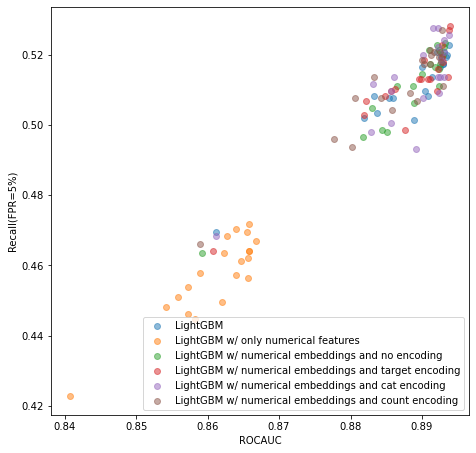

In [22]:
enc=['no','target','cat','count']
plt.scatter(auc_lgbm,recall_lgbm, alpha=0.5,label='LightGBM')
plt.scatter(auc_lgbm_num,recall_lgbm_num, alpha=0.5,label='LightGBM w/ only numerical features')
for j in range(0,4):
    plt.scatter(auc_lgbm_numenc[j],recall_lgbm_numenc[j], alpha=0.5,label='LightGBM w/ numerical embeddings and {} encoding'.format(enc[j]))

plt.legend()
plt.xlabel('ROCAUC')
plt.ylabel('Recall(FPR=5%)')
plt.rcParams['figure.figsize']=(7.5,7.5)
plt.show()

# Results for Category Encodings and Normalization

In [27]:
#First, let us look at the effects of normalization seperatly
auc_scores=np.zeros([4,4,20])
recall_scores=np.zeros([4,4,20])
auc_scores_test=np.zeros([4,4,20])
recall_scores_test=np.zeros([4,4,20])
k=0
for encoding in ['target','cat','count','simple']:
    j=0
    if encoding!='simple':
        encoder_link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
        encoder = joblib.load(encoder_link)
        xval=encoder.transform(X_val)
        xtest=encoder.transform(X_test)
    else:
        xval=X_val.copy(deep=True)
        xtest=X_test.copy(deep=True)
    for normalization in ['None','Zscore','MinMax','Median']:
        if encoding=='simple':
            X_val_normalized=mlp_pipeline.normalization_transform(xval,normalization,cont_cols).float()
            X_test_normalized=mlp_pipeline.normalization_transform(xtest,normalization,cont_cols).float()
        else:
            X_val_normalized=mlp_pipeline.normalization_transform(xval,normalization,X_val.columns).float()
            X_test_normalized=mlp_pipeline.normalization_transform(xtest,normalization,X_test.columns).float()
            
        for i in range(0,20):
            if(encoding=='target' and normalization=='Median' and i==19):
                break
            link="tab_norm_folder/tab_norm_folder/mlp_{}{}{}.pkl".format(encoding,normalization,i)
            file = open(link,'rb')
            model = CPU_Unpickler(file).load()
            model.eval()
            predict = model(X_val_normalized).detach().numpy()
            predict_test = model(X_test_normalized).detach().numpy()
            auc_scores[k][j][i]=skl.metrics.roc_auc_score(y_val,predict)
            auc_scores_test[k][j][i]=skl.metrics.roc_auc_score(y_test,predict_test)
            recall_scores_test[k][j][i]=find_optimal_recall(y_test,predict_test,0.05)
        del X_val_normalized
        del X_test_normalized
        gc.collect
        j=j+1
    k=k+1
    


(0.3, 0.6)

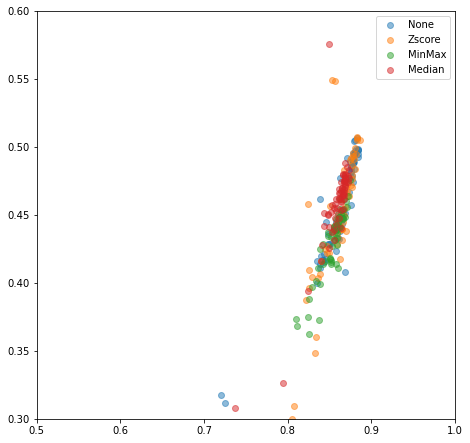

In [278]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for i in range(0,4):
    plt.scatter(auc_scores[:][i],recall_scores[:][i],alpha=0.5,label=norms[i])
plt.legend()
plt.xlim(0.5,1)
plt.ylim(0.3,0.6)

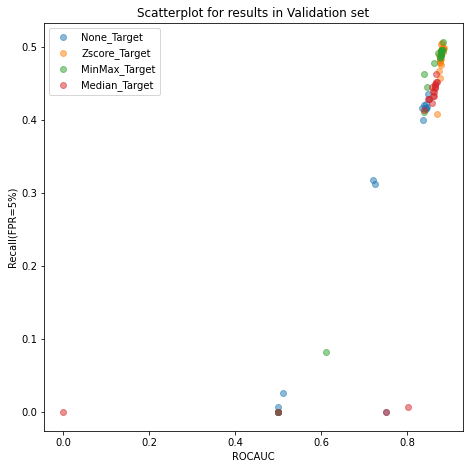

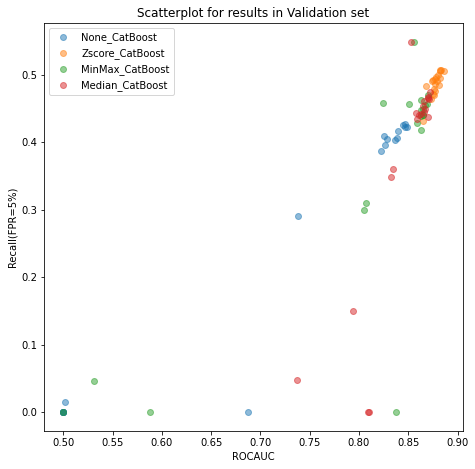

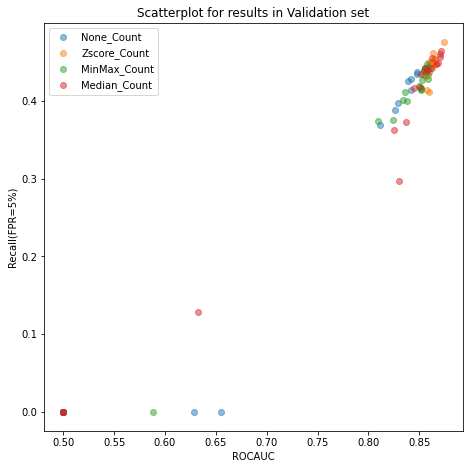

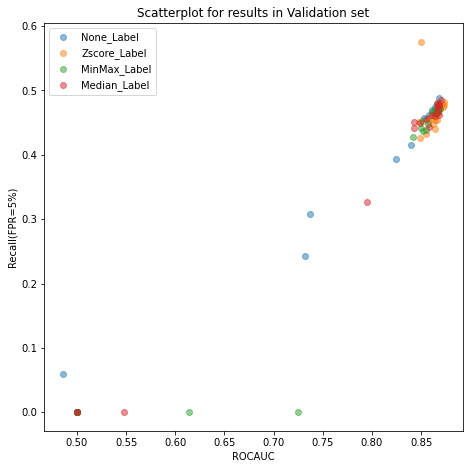

In [219]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    for i in range(0,4):
        label=('{}_{}'.format(norms[i],encs[j]))
        plt.scatter(auc_scores[j][i],recall_scores[j][i],alpha=0.5,label=label)
        plt.legend(label)
    
    plt.title('Scatterplot for results in Validation set')
    plt.legend()
    plt.xlabel('ROCAUC')
    plt.ylabel('Recall(FPR=5%)')
    plt.rcParams['figure.figsize']=(7.5,7.5)
    plt.show()


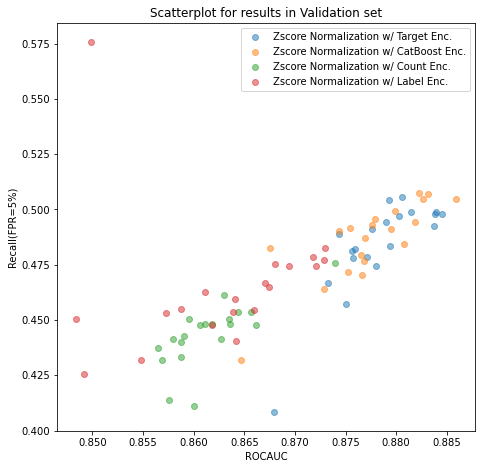

In [12]:
norms=['Zscore']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{} Normalization w/ {} Enc.'.format(norms[0],encs[j]))
    plt.scatter(auc_scores[j][1],recall_scores[j][1],alpha=0.5,label=label)
    plt.legend(label)
plt.xlabel('ROCAUC')
plt.ylabel('Recall(FPR=5%)')
plt.title('Scatterplot for results in Validation set')
plt.legend()
plt.rcParams['figure.figsize']=(7.5,7.5)
plt.show()


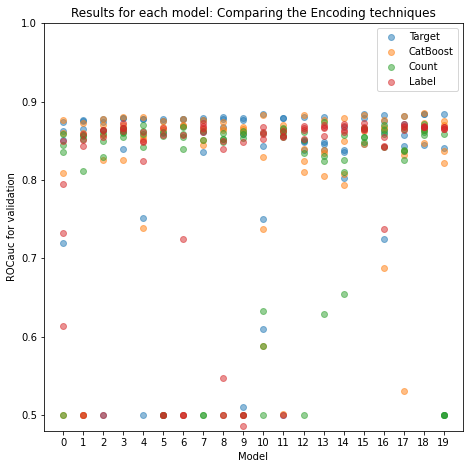

In [13]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{}'.format(encs[j]))
    
    plt.scatter(np.resize(np.arange(20),20*4),auc_scores[j].flatten(),alpha=0.5,label=label)
    plt.legend(label)
plt.title('Results for each model: Comparing the Encoding techniques')    
plt.xlabel('Model')
plt.ylabel('ROCauc for validation')
plt.ylim(0.48,1)
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(10,7.5)
plt.show()

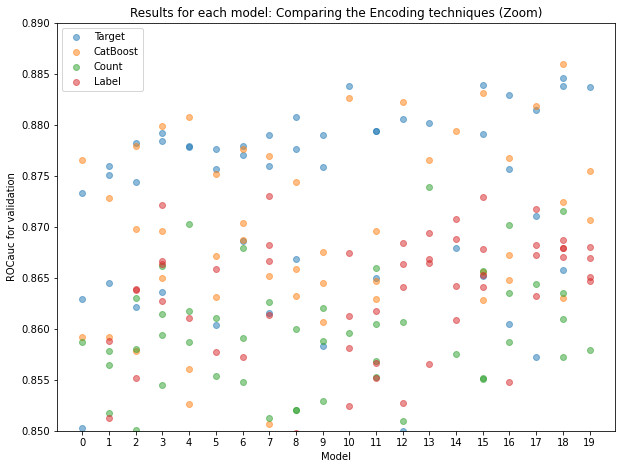

In [14]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{}'.format(encs[j]))
    
    plt.scatter(np.resize(np.arange(20),20*4),auc_scores[j].flatten(),alpha=0.5,label=label)
    plt.legend(label)
    
plt.title('Results for each model: Comparing the Encoding techniques (Zoom)')
plt.ylim(0.85,0.89)
plt.xlabel('Model')
plt.ylabel('ROCauc for validation')
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(10,7.5)
plt.show()

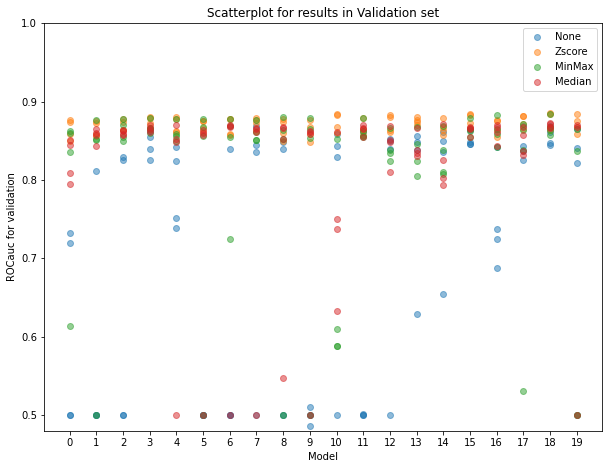

In [15]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{}'.format(norms[j]))
    
    plt.scatter(np.resize(np.arange(20),20*4),auc_scores[:,j].flatten(),alpha=0.5,label=label)
    plt.legend(label)
plt.title('Results for each model: Comparing the Normalization techniques')    
plt.title('Scatterplot for results in Validation set')
plt.xlabel('Model')
plt.ylabel('ROCauc for validation')
plt.ylim(0.48,1)
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(10,7.5)
plt.show()

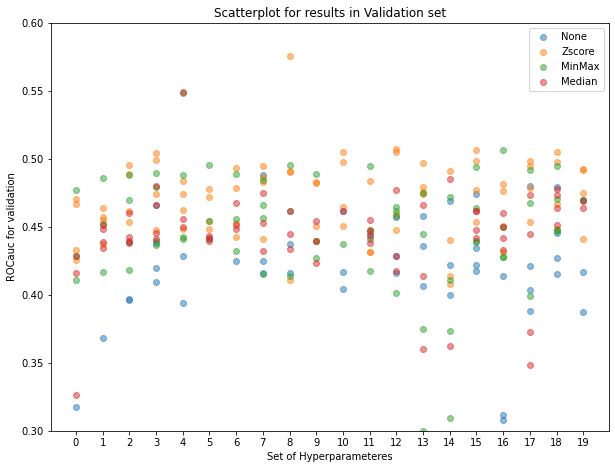

In [290]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{}'.format(norms[j]))
    
    plt.scatter(np.resize(np.arange(20),20*4),recall_scores[:,j].flatten(),alpha=0.5,label=label)
    plt.legend(label)
plt.title('Results for each model: Comparing the Normalization techniques')    
plt.title('Scatterplot for results in Validation set')
plt.xlabel('Set of Hyperparameteres')
plt.ylabel('ROCauc for validation')
plt.ylim(0.3,0.6)
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(10,7.5)
plt.show()

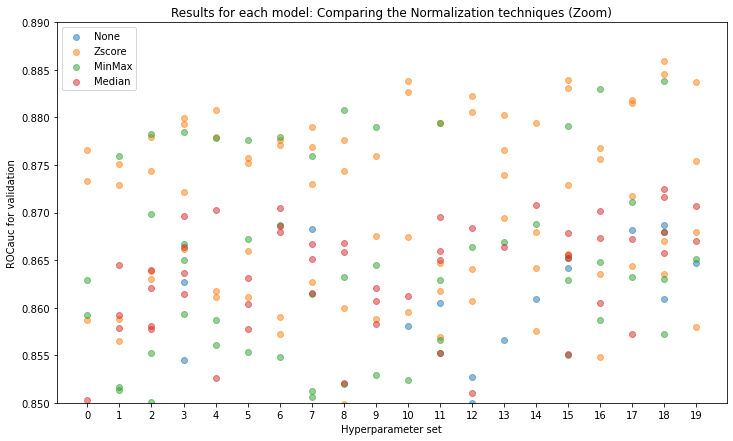

In [286]:
norms=['None','Zscore','MinMax','Median']
encs=['Target','CatBoost','Count','Label']
for j in range(0,4):
    label=('{}'.format(norms[j]))
    
    plt.scatter(np.resize(np.arange(20),20*4),auc_scores[:,j].flatten(),alpha=0.5,label=label)
    plt.legend(label)
    
plt.title('Results for each model: Comparing the Normalization techniques (Zoom)')
plt.ylim(0.85,0.89)
plt.xlabel('Hyperparameter set')
plt.ylabel('ROCauc for validation')
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(12,7)
plt.show()

# Embedding Results

In [28]:
x_train,x_test,x_val=embedding_pipeline.aggregate_low_card_BAF(X_train,X_test,X_val,cat_cols) # aggregate categories with low cardinality

#Dividing numerical and categorical data
x_train_cont=x_train[cont_cols]
x_train_cat=x_train[cat_cols]
x_test_cont=x_test[cont_cols]
x_test_cat=x_test[cat_cols]
x_val_cont=x_val[cont_cols]
x_val_cat=x_val[cat_cols]


In [29]:
auc_embs=np.zeros([3,4,20])
recall_embs=np.zeros([3,4,20])
auc_embs_test=np.zeros([3,4,20])
recall_embs_test=np.zeros([3,4,20])
norms=['None','Zscore','MinMax','Median']
x_val_aux_cat=mlp_pipeline.normalization_transform(x_val_cat,'None',[]).long()
x_test_aux_cat=mlp_pipeline.normalization_transform(x_test_cat,'None',[]).long()
k=0
for dim in ['sqrt','variational','1dimensional']:    
    j=0
    for normalization in norms:
        max_auc=0
        xval_aux_cont=mlp_pipeline.normalization_transform(x_val_cont,normalization,cont_cols)
        xtest_aux_cont=mlp_pipeline.normalization_transform(x_test_cont,normalization,cont_cols)
        for i in range(0,20):
            link='tab_norm_folder/tab_norm_folder/embedding/mlp_simple{}{}{}.pkl'.format(dim,normalization,i)
            file = open(link,'rb')
            model = CPU_Unpickler(file).load()
            model.eval()
            predict = model(xval_aux_cont.float(),x_val_aux_cat).detach().numpy()
            auc_embs[k][j][i]=skl.metrics.roc_auc_score(y_val,predict)
            recall_embs[k][j][i]=find_optimal_recall(y_val,predict,0.05)
            predict_test = model(xtest_aux_cont.float(),x_test_aux_cat).detach().numpy()
            auc_embs_test[k][j][i]=skl.metrics.roc_auc_score(y_test,predict_test)
            recall_embs_test[k][j][i]=find_optimal_recall(y_test,predict_test,0.05)
                        
        j=j+1
        del xval_aux_cont
        del xtest_aux_cont
        gc.collect()
    k=k+1


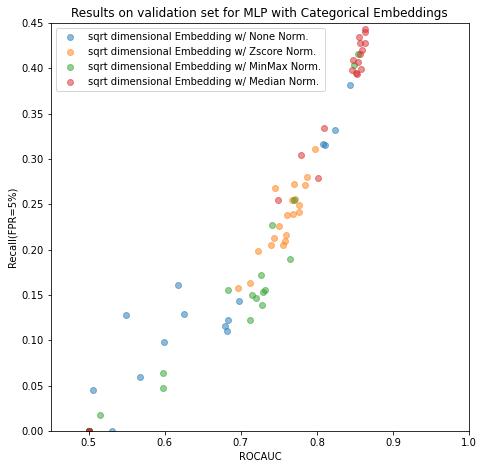

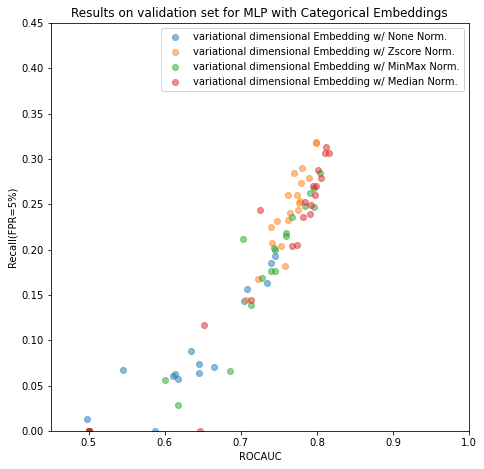

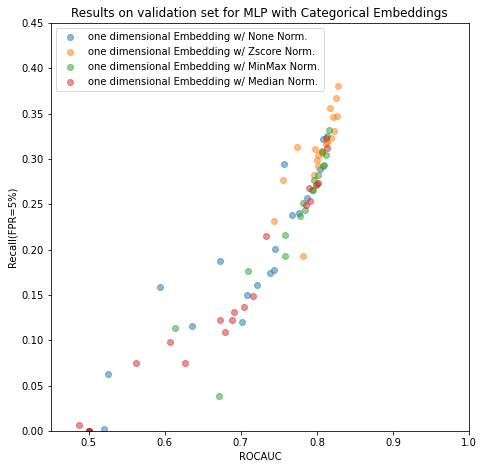

In [36]:
dims=['sqrt','variational','one']
for j in range(0,3):
    for i in range(0,4):
        label=('{} dimensional Embedding w/ {} Norm.'.format(dims[j],norms[i]))
        plt.scatter(auc_embs[j][i],recall_embs[j][i],alpha=0.5,label=label)
        plt.legend(label)
    
    j=j+1
    plt.legend()
    plt.rcParams['figure.figsize']=(7.5,7.5)
    plt.title('Results on validation set for MLP with Categorical Embeddings')
    plt.xlim(0.45,1)
    plt.ylim(0,0.45)
    plt.ylabel('Recall(FPR=5%)')
    plt.xlabel('ROCAUC')
    plt.show()


# Numerical Encoding results (dim=10)

In [37]:
from rtdl.rtdl import data

In [38]:
auc_encs=np.zeros([4,20])
recall_encs=np.zeros([4,20])
auc_encs_test=np.zeros([4,20])
recall_encs_test=np.zeros([4,20])
link="tab_norm_folder/tab_norm_folder/encoders/numerical_encoder_dim10.pkl"
file = open(link,'rb')
numerical_encoder =renamed_load(file)
transformed_val=numerical_encoder.transform(torch.tensor(X_val[cont_cols.difference(['device_fraud_count'])].values))
transformed_test=numerical_encoder.transform(torch.tensor(X_test[cont_cols.difference(['device_fraud_count'])].values))

j=0
for encoding in ['label','count','cat','target']:
    max_auc=0
    if encoding!='label':
        link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
        file = open(link,'rb')
        cat_encoder = joblib.load(link)
        x_val_cat_aux=cat_encoder.transform(X_val)[cat_cols]
        x_test_cat_aux=cat_encoder.transform(X_test)[cat_cols]
    else:
        x_val_cat_aux=X_val[cat_cols]
        x_test_cat_aux=X_test[cat_cols]
    for i in range(0,20):

        model_link="tab_norm_folder-20230202/tab_norm_folder/numerical_embeddings/num_enc_mlp_{}{}_dim.pkl".format(encoding,i)
        file = open(model_link,'rb')
        model=CPU_Unpickler(file).load()
        model.eval()
        predict=model(torch.cat([transformed_val,torch.tensor(x_val_cat_aux.values)],1).float()).detach().numpy()
        auc_encs[j][i]=skl.metrics.roc_auc_score(y_val,predict)
        recall_encs[j][i]=find_optimal_recall(y_val,predict,0.05)
        predict_test=model(torch.cat([transformed_test,torch.tensor(x_test_cat_aux.values)],1).float()).detach().numpy()
        auc_encs_test[j][i]=skl.metrics.roc_auc_score(y_test,predict_test)
        recall_encs_test[j][i]=find_optimal_recall(y_test,predict_test,0.05)

    j=j+1
    del x_val_cat_aux
    gc.collect()
    

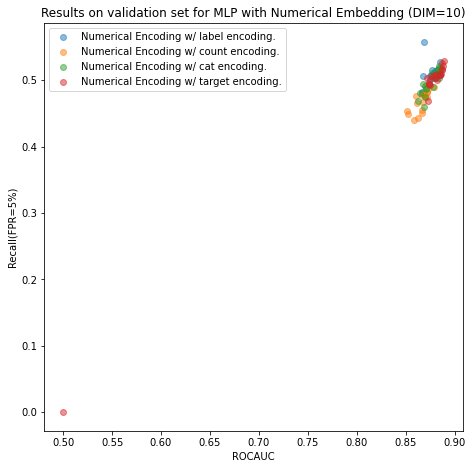

In [181]:
encs=['label','count','cat','target']
for i in range(0,4):
    label=('Numerical Encoding w/ {} encoding.'.format(encs[i]))
    plt.scatter(auc_encs[i],recall_encs[i],alpha=0.5,label=label)
    plt.legend(label)
    

plt.legend()
plt.rcParams['figure.figsize']=(7.5,7.5)
plt.title('Results on validation set for MLP with Numerical Embedding (DIM=10)')
plt.ylabel('Recall(FPR=5%)')
plt.xlabel('ROCAUC')
plt.show()


    


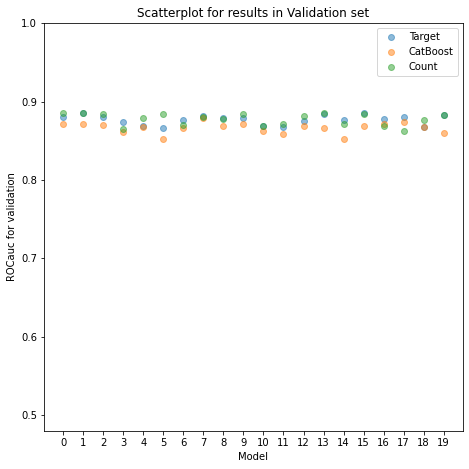

In [73]:
encs=['Target','CatBoost','Count','Label']
for j in range(0,3):
    label=('{}'.format(encs[j]))
    
    plt.scatter((np.arange(20)),auc_encs[j],alpha=0.5,label=label)
    plt.legend(label)
plt.title('Results for each model: Comparing the encoding techniques')    
plt.title('Scatterplot for results in Validation set')
plt.xlabel('Model')
plt.ylabel('ROCauc for validation')
plt.ylim(0.48,1)
plt.legend()
plt.xticks(range(0,20))
plt.rcParams['figure.figsize']=(10,7.5)
plt.show()

# Numerical Encoding and Categorical Embeddings

In [74]:
x_test_aux_cat=mlp_pipeline.normalization_transform(x_test_cat,'None',[]).long()
x_val_aux_cat=mlp_pipeline.normalization_transform(x_val_cat,'None',[]).long()

max_auc=0

recall_encs_embs=np.zeros(20)
auc_encs_embs=np.zeros(20)
link="tab_norm_folder/tab_norm_folder/encoders/numerical_encoder_dim10.pkl"
file = open(link,'rb')
numerical_encoder =renamed_load(file)
transformed_val=numerical_encoder.transform(torch.tensor(X_val[cont_cols.difference(['device_fraud_count'])].values))

for i in range(0,20):
        
        link="tab_norm_folder/tab_norm_folder/embedding/mlp_num_enc10{}{}.pkl".format('sqrt',i)
        file = open(link,'rb')
        model=CPU_Unpickler(file).load()
        model.eval()
        predict = model(transformed_val.float(),x_val_aux_cat).detach().numpy()
        auc_encs_embs[i]=skl.metrics.roc_auc_score(y_val,predict)
        recall_encs_embs[i]=find_optimal_recall(y_val,predict,0.05)


# Tabtransformer

In [53]:
X_test_norm=mlp_pipeline.z_score(X_test,cont_cols)
X_val_norm=mlp_pipeline.z_score(X_val,cont_cols)


In [54]:
recall_tabtransformer=np.zeros([20])
auc_tabtransformer=np.zeros([20])
recall_tabtransformer_test=np.zeros([20])
auc_tabtransformer_test=np.zeros([20])
for i in range(8,20):
    link='BAF_tabtransformer/tabtransformer_zscore{}.pkl'.format(i)
    file=open(link,'rb')
    model=joblib.load(file)
    predict=model.predict(X_val_norm)['1_probability']
    predict_test=model.predict(X_test_norm)['1_probability']
    joblib.dump(model.predict(X_test_norm)['1_probability'],'res_predictions/yhat{}.pkl'.format(i))
    predict_test=joblib.load('res_predictions/yhat{}.pkl'.format(i))
    recall_tabtransformer[i]=find_optimal_recall(y_val,predict,0.05)
    auc_tabtransformer[i]=skl.metrics.roc_auc_score(y_val,predict)
    recall_tabtransformer_test[i]=find_optimal_recall(y_test,predict_test,0.05)
    auc_tabtransformer_test[i]=skl.metrics.roc_auc_score(y_test,predict_test)

Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ritas\anaconda3\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Output()

Output()

Output()

In [95]:
for j in range(0,7):
    predict=joblib.load('res_predictions/yval{}.pkl'.format(j))
    recall_tabtransformer[j]=find_optimal_recall(y_val,predict,0.05)
    auc_tabtransformer[j]=skl.metrics.roc_auc_score(y_val.sort_index(),predict.sort_index())
    predict_test=joblib.load('res_predictions/yhat{}.pkl'.format(j))
    recall_tabtransformer_test[j]=find_optimal_recall(y_test.sort_index(),predict_test.sort_index(),0.05)
    auc_tabtransformer_test[j]=skl.metrics.roc_auc_score(y_test.sort_index(),predict_test.sort_index())


In [97]:
auc_tabtransformer

array([0.85631387, 0.82580163, 0.87783502, 0.85845702, 0.86311308,
       0.75582584, 0.79127563, 0.50749332, 0.76758358, 0.87926519,
       0.79851661, 0.79862333, 0.83159382, 0.79579882, 0.7811421 ,
       0.77711674, 0.82086888, 0.67246138, 0.86199774, 0.76124006])

Text(0.5, 0, 'ROCAUC')

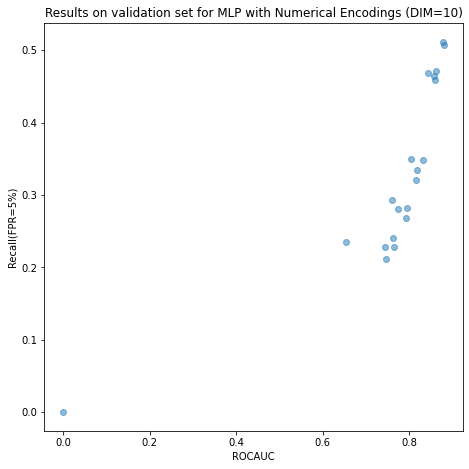

In [98]:
plt.scatter(auc_tabtransformer_test,recall_tabtransformer_test,alpha=0.5)

plt.title('Results on validation set for MLP with Numerical Encodings (DIM=10)')
plt.ylabel('Recall(FPR=5%)')
plt.xlabel('ROCAUC')

In [58]:
print('Average AUC on validation set:',np.mean(auc_tabtransformer))
print('Average Recall on validation set:',np.mean(recall_tabtransformer))

Average AUC on validation set: 0.6782006685683377
Average Recall on validation set: 0.21282758620689654


# Test Scores

Lets first make the selection based off the AUC scores

In [39]:
link="tab_norm_folder/tab_norm_folder/encoders/numerical_encoder_dim10.pkl"
file = open(link,'rb')
numerical_encoder =renamed_load(file)
transformed_test=numerical_encoder.transform(torch.tensor(X_test[cont_cols.difference(['device_fraud_count'])].values))

In [464]:
recall_test_emb=np.zeros(4)
auc_test_emb=np.zeros(4)

x_test_aux_cat=mlp_pipeline.normalization_transform(x_test_cat,'None',[]).long()
i=0
for dim in ['sqrt','variational','1dimensional']:    
    j=0
    for normalization in ['None','Zscore','MinMax','Median']:
        x_test_aux_cont=mlp_pipeline.normalization_transform(x_test_cont,normalization,cont_cols)
        index=np.argmax(auc_embs[i][j])
        link='tab_norm_folder/tab_norm_folder/embedding/mlp_simple{}{}{}.pkl'.format(dim,normalization,index)
        file = open(link,'rb')
        model = CPU_Unpickler(file).load()
        model.eval()
        
        predict = model(x_test_aux_cont.float(),x_test_aux_cat).detach().numpy()
        auc=skl.metrics.roc_auc_score(y_test,predict)
        recall=find_optimal_recall(y_test,predict,0.05)
        print('MLP with  dimensional',dim,'categorical embeddings and ',normalization,'------',np.round(auc,5),' & ',np.round(recall,5))
        j=j+1
        del x_test_aux_cont

    i=i+1
    gc.collect()


MLP with  dimensional sqrt categorical embeddings and  None ------ 0.83205  &  0.36345
MLP with  dimensional sqrt categorical embeddings and  Zscore ------ 0.81138  &  0.33964
MLP with  dimensional sqrt categorical embeddings and  MinMax ------ 0.84331  &  0.42437
MLP with  dimensional sqrt categorical embeddings and  Median ------ 0.76643  &  0.19258
MLP with  dimensional variational categorical embeddings and  None ------ 0.84697  &  0.39776
MLP with  dimensional variational categorical embeddings and  Zscore ------ 0.8501  &  0.45588
MLP with  dimensional variational categorical embeddings and  MinMax ------ 0.84306  &  0.41106
MLP with  dimensional variational categorical embeddings and  Median ------ 0.80373  &  0.30252
MLP with  dimensional 1dimensional categorical embeddings and  None ------ 0.72582  &  0.26751
MLP with  dimensional 1dimensional categorical embeddings and  Zscore ------ 0.77146  &  0.2507
MLP with  dimensional 1dimensional categorical embeddings and  MinMax ----

In [78]:

i=0
for encoding in ['label','count','cat','target']:
    max_auc=0
    if encoding!='label':
        link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
        file = open(link,'rb')
        cat_encoder = joblib.load(link)
        x_test_aux_cat=cat_encoder.transform(X_test)[cat_cols]
    else:
        x_test_aux_cat=X_test[cat_cols]
    index=np.argmax(auc_encs[i])
    link="tab_norm_folder/tab_norm_folder/numerical_embeddings/num_enc_mlp_{}{}_dim.pkl".format(encoding,index)
    file = open(link,'rb')
    model = CPU_Unpickler(file).load()
    model.eval()
    predict=model(torch.cat([transformed_test,torch.tensor(x_test_aux_cat.values)],1).float()).detach().numpy()
    auc=skl.metrics.roc_auc_score(y_test,predict)
    recall=find_optimal_recall(y_test,predict,0.05)
    print('Numerical embedding with ',encoding,' encoding ----',np.round(auc,5),' & ',np.round(recall,5))
    del x_test_aux_cat
    gc.collect()
    i=i+1
    


Numerical embedding with  label  encoding ---- 0.8927  &  0.55602
Numerical embedding with  count  encoding ---- 0.88373  &  0.52941
Numerical embedding with  cat  encoding ---- 0.89168  &  0.56513
Numerical embedding with  target  encoding ---- 0.89653  &  0.57073


In [80]:
x_test_aux_cat=mlp_pipeline.normalization_transform(x_test_cat,'None',[]).long()

index=np.argmax(auc_encs_embs)
link="tab_norm_folder/tab_norm_folder/embedding/mlp_num_enc10{}{}.pkl".format('sqrt',index)
file = open(link,'rb')
best_model_numcat=CPU_Unpickler(file).load()
best_model_numcat.eval()
predict=best_model_numcat(transformed_test.float(),x_test_aux_cat).detach().numpy()
auc=skl.metrics.roc_auc_score(y_test,predict)
recall=find_optimal_recall(y_test,predict,0.05)
print('MLP with sqrt dimensional categorical embedding and numerical encoding',round(auc,5),round(recall,5))

MLP with sqrt dimensional categorical embedding and numerical encoding 0.86556 0.47549


In [440]:
norms=['None','Zscore','MinMax','Median']
encs=['target','cat','count','simple']


best_link=np.array(np.zeros([4,4]),dtype=object)


for j in range(0,4):
    if encs[j]!='simple':
        encoder_link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encs[j])
        encoder = joblib.load(encoder_link)
        xtest=encoder.transform(X_test)
    else:
        xtest=X_test.copy(deep=True)
    for i in range(0,4):
        if encs[j]=='simple':
            X_test_normalized=mlp_pipeline.normalization_transform(xtest,norms[i],cont_cols).float()
        else:
            X_test_normalized=mlp_pipeline.normalization_transform(xtest,norms[i],X_val.columns).float()
                    
        index=np.argmax(auc_scores[j][i]) 
        best_link[i][j]="tab_norm_folder-20230202/tab_norm_folder/mlp_{}{}{}.pkl".format(encs[j],norms[i],index)
        file = open(best_link[i][j],'rb')
        model = CPU_Unpickler(file).load()
        model.eval()
        predict = model(X_test_normalized).detach().numpy()
        auc=skl.metrics.roc_auc_score(y_test,predict)
        recall=find_optimal_recall(y_test,predict,0.05)
        print('MLP with ',encs[j],' encoding and ',norms[i],' normalization :',round(auc,5)," & ",round(recall,5))
        del X_test_normalized
        gc.collect()

MLP with  target  encoding and  None  normalization : 0.85281  &  0.43557
MLP with  target  encoding and  Zscore  normalization : 0.88508  &  0.52731
MLP with  target  encoding and  MinMax  normalization : 0.88571  &  0.53641
MLP with  target  encoding and  Median  normalization : 0.86455  &  0.4944
MLP with  cat  encoding and  None  normalization : 0.85169  &  0.45238
MLP with  cat  encoding and  Zscore  normalization : 0.88746  &  0.52801
MLP with  cat  encoding and  MinMax  normalization : 0.8653  &  0.47619
MLP with  cat  encoding and  Median  normalization : 0.86812  &  0.5014
MLP with  count  encoding and  None  normalization : 0.86287  &  0.46569
MLP with  count  encoding and  Zscore  normalization : 0.87303  &  0.5
MLP with  count  encoding and  MinMax  normalization : 0.86868  &  0.4986
MLP with  count  encoding and  Median  normalization : 0.84801  &  0.42297
MLP with  simple  encoding and  None  normalization : 0.8752  &  0.4923
MLP with  simple  encoding and  Zscore  normal

In [40]:
index=np.argmax(auc_lgbm)
link="LGBM_BAF/lgbm_{}.pkl".format(index)
file = open(link,'rb')
model =joblib.load(file)
predict=model.predict_proba(X_test)[:,1]
auc=skl.metrics.roc_auc_score(y_test,predict)
recall=find_optimal_recall(y_test,predict,0.05)
print('LightGBM: ', round(auc,5),round(recall,5))

index=np.argmax(auc_lgbm_num)
link="LGBM_BAF/lgbm_onlycontfeatures{}.pkl".format(index)
file = open(link,'rb')
model =joblib.load(file)
predict=model.predict_proba(X_test[cont_cols])[:,1]
auc=skl.metrics.roc_auc_score(y_test,predict)
recall=find_optimal_recall(y_test,predict,0.05)
print('LightGBM using only numerical features: ', round(auc,5),round(recall,5))

i=0
for encoding in ['label','target','cat','count']:
    if encoding!='label':
        encoder_link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
        encoder = joblib.load(encoder_link)
        xtest=encoder.transform(X_test)
    else:
        xtest=X_test
    X_test_aux=torch.cat([torch.tensor(xtest[cat_cols].values),transformed_test],1).float()
    
    index=np.argmax(auc_lgbm_numenc[i])
    link='LGBM_BAF/lgbm_numericalemb_{}{}.pkl'.format(encoding,index)
    file = open(link,'rb')
    model =joblib.load(file)
    predict=model.predict_proba(X_test_aux)[:,1]
    auc=skl.metrics.roc_auc_score(y_test,predict)
    recall=find_optimal_recall(y_test,predict,0.05)
    print('LightGBM with numerical embedding and ',encoding,' encoding: ',np.round(auc,5),' & ',np.round(recall,5))

LightGBM:  0.89902 0.57983
LightGBM using only numerical features:  0.8737 0.4972
LightGBM with numerical embedding and  label  encoding:  0.8994  &  0.58403
LightGBM with numerical embedding and  target  encoding:  0.89993  &  0.58193
LightGBM with numerical embedding and  cat  encoding:  0.89942  &  0.57563
LightGBM with numerical embedding and  count  encoding:  0.89836  &  0.57843


In [43]:
j=0
for encoding in ['target','cat','count']:
    encoder_link="tab_norm_folder/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xtest=encoder.transform(X_test)
    np.argmax(auc_lgbm_simple[j])
    link='LGBM_BAF/lgbm_simple_{}{}.pkl'.format(encoding,index)
    file = open(link,'rb')
    model =joblib.load(file)
    predict=model.predict_proba(xtest)[:,1]
    auc=skl.metrics.roc_auc_score(y_test,predict)
    recall=find_optimal_recall(y_test,predict,0.05)
    print('LightGBM with',encoding,'  encoding: ',np.round(auc,5),' & ',np.round(recall,5))    
    del xtest
    gc.collect()
    j=j+1

LightGBM with target   encoding:  0.89839  &  0.57563
LightGBM with cat   encoding:  0.89793  &  0.57283
LightGBM with count   encoding:  0.89706  &  0.57913


In [75]:
index=np.argmax(auc_tabtransformer)
predict=joblib.load('res_predictions/yhat{}.pkl'.format(index))
auc=skl.metrics.roc_auc_score(y_test,predict)
recall=find_optimal_recall(y_test,predict,0.05)
print(round(auc,5),'&',round(recall,5))

0.87952 & 0.507


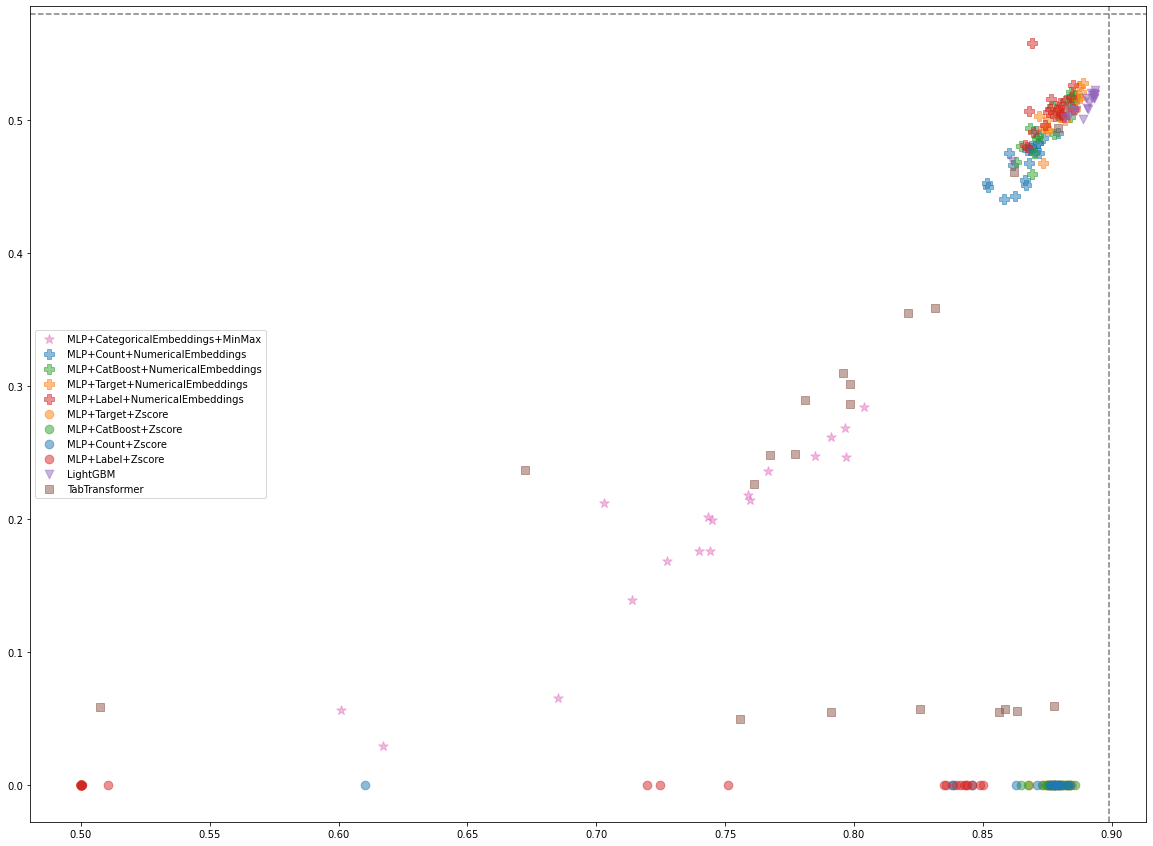

In [100]:
plt.scatter(auc_embs[1][2],recall_embs[1][2],alpha=0.5,marker='*',label='MLP+CategoricalEmbeddings+MinMax',color='tab:pink',s=100)
plt.scatter(auc_encs[1],recall_encs[1],alpha=0.5,marker='P',label='MLP+Count+NumericalEmbeddings',color='tab:blue',s=100)
plt.scatter(auc_encs[2],recall_encs[2],alpha=0.5,marker='P',label='MLP+CatBoost+NumericalEmbeddings',color='tab:green',s=100)
plt.scatter(auc_encs[3],recall_encs[3],alpha=0.5,marker='P',label='MLP+Target+NumericalEmbeddings',color='tab:orange',s=100)
plt.scatter(auc_encs[0],recall_encs[0],alpha=0.5,marker='P',label='MLP+Label+NumericalEmbeddings',color='tab:red',s=100)

plt.scatter(auc_scores[0][1],recall_scores[0][1],alpha=0.5,label='MLP+Target+Zscore',color='tab:orange',s=75)
plt.scatter(auc_scores[1][1],recall_scores[1][1],alpha=0.5,label='MLP+CatBoost+Zscore',color='tab:green',s=75)
plt.scatter(auc_scores[0][2],recall_scores[0][2],alpha=0.5,label='MLP+Count+Zscore',color='tab:blue',s=75)
plt.scatter(auc_scores[0][0],recall_scores[0][0],alpha=0.5,label='MLP+Label+Zscore',color='tab:red',s=75)

plt.scatter(auc_lgbm,recall_lgbm,alpha=0.5,marker='v',color='tab:purple',s=75,label='LightGBM')
plt.scatter(auc_tabtransformer,recall_tabtransformer,alpha=0.5,marker='s',color='tab:brown',s=75,label='TabTransformer')

plt.rcParams['figure.figsize']=(20,15)
plt.axvline(x=0.89902,linestyle='dashed',color='grey')
plt.axhline(y=0.57983,linestyle='dashed',color='grey')
#plt.xlim(0.8,0.92)
#plt.ylim(0.3,0.6)
plt.legend()

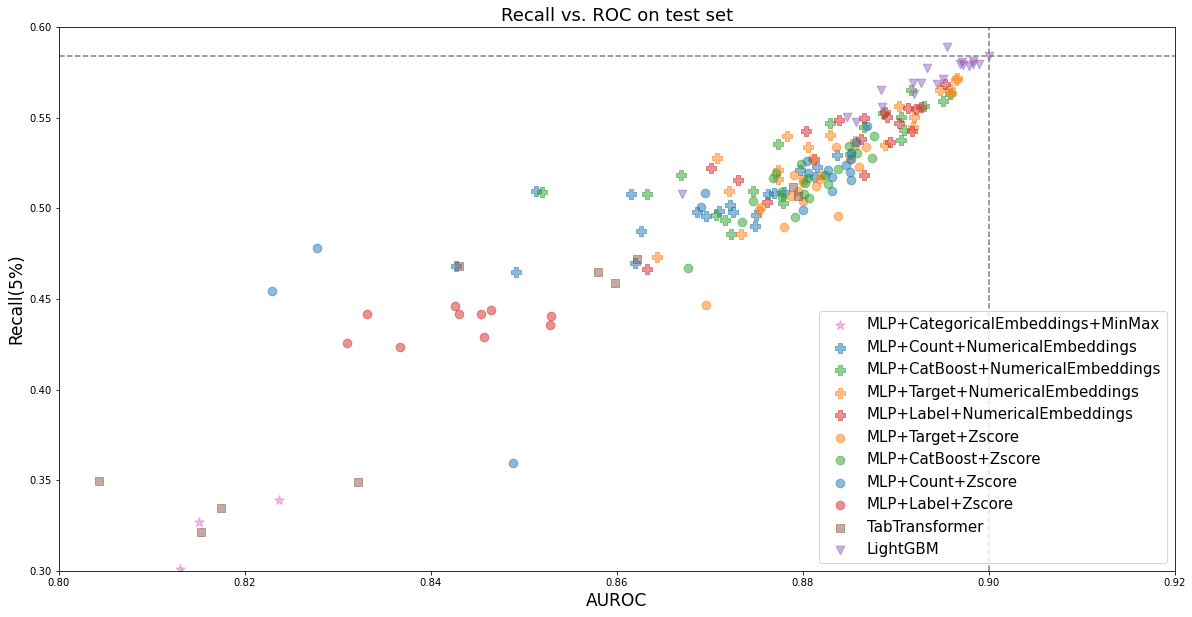

In [110]:
plt.scatter(auc_embs_test[1][2],recall_embs_test[1][2],alpha=0.5,marker='*',label='MLP+CategoricalEmbeddings+MinMax',color='tab:pink',s=100)
plt.scatter(auc_encs_test[1],recall_encs_test[1],alpha=0.5,marker='P',label='MLP+Count+NumericalEmbeddings',color='tab:blue',s=100)
plt.scatter(auc_encs_test[2],recall_encs_test[2],alpha=0.5,marker='P',label='MLP+CatBoost+NumericalEmbeddings',color='tab:green',s=100)
plt.scatter(auc_encs_test[3],recall_encs_test[3],alpha=0.5,marker='P',label='MLP+Target+NumericalEmbeddings',color='tab:orange',s=100)
plt.scatter(auc_encs_test[0],recall_encs_test[0],alpha=0.5,marker='P',label='MLP+Label+NumericalEmbeddings',color='tab:red',s=100)

plt.scatter(auc_scores_test[0][1],recall_scores_test[0][1],alpha=0.5,label='MLP+Target+Zscore',color='tab:orange',s=75)
plt.scatter(auc_scores_test[1][1],recall_scores_test[1][1],alpha=0.5,label='MLP+CatBoost+Zscore',color='tab:green',s=75)
plt.scatter(auc_scores_test[0][2],recall_scores_test[0][2],alpha=0.5,label='MLP+Count+Zscore',color='tab:blue',s=75)
plt.scatter(auc_scores_test[0][0],recall_scores_test[0][0],alpha=0.5,label='MLP+Label+Zscore',color='tab:red',s=75)
plt.scatter(auc_tabtransformer_test,recall_tabtransformer_test,alpha=0.5,marker='s',color='tab:brown',s=75,label='TabTransformer')

plt.scatter(auc_lgbm_test,recall_lgbm_test,alpha=0.5,marker='v',color='tab:purple',s=75,label='LightGBM')

plt.rcParams['figure.figsize']=(20,10)
plt.axvline(x=np.max(auc_lgbm_test),linestyle='dashed',color='grey')
plt.axhline(y= recall_lgbm_test[np.argmax(auc_lgbm_test)],linestyle='dashed',color='grey')
plt.xlim(0.8,0.92)
plt.ylim(0.3,0.6)
plt.xlabel('AUROC',fontsize=17)
plt.ylabel('Recall(5%)',fontsize=17)
plt.title('Recall vs. ROC on test set',fontsize=18)
plt.legend( prop={'size': 15})

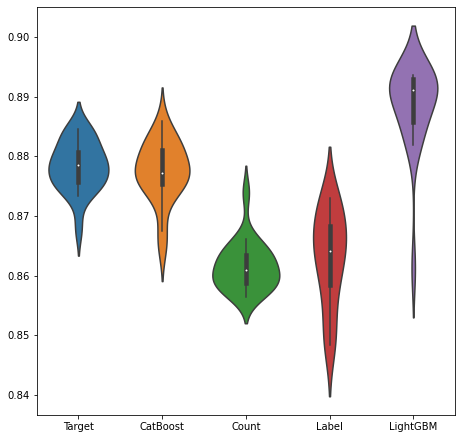

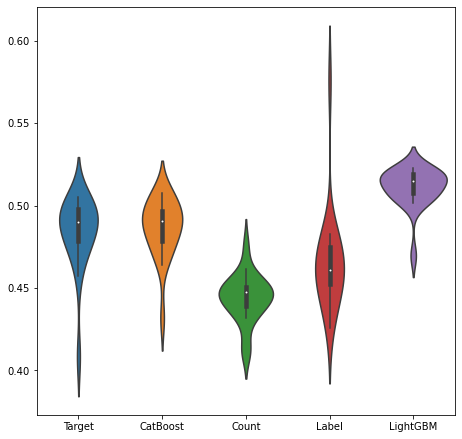

In [277]:
sns.violinplot(data=[auc_scores[0][1].T,auc_scores[1][1].T,auc_scores[2][1].T,auc_scores[3][1].T, auc_lgbm.T],split=True)
plt.xticks([0,1,2,3,4],['Target','CatBoost','Count','Label','LightGBM'])
plt.show()
sns.violinplot(data=[recall_scores[0][1].T,recall_scores[1][1].T,recall_scores[2][1].T,recall_scores[3][1].T,recall_lgbm.T])
plt.xticks([0,1,2,3,4],['Target','CatBoost','Count','Label','LightGBM'])

plt.show()

In [299]:
Y=np.array([auc_scores[0][1].T,auc_encs[3],auc_scores[1][1].T,auc_encs[2],auc_scores[2][1].T,auc_encs[1],auc_scores[3][1].T,auc_encs[0]])

C:\Users\ritas\anaconda3\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Swarmplot of ROCAUC results for validation set')

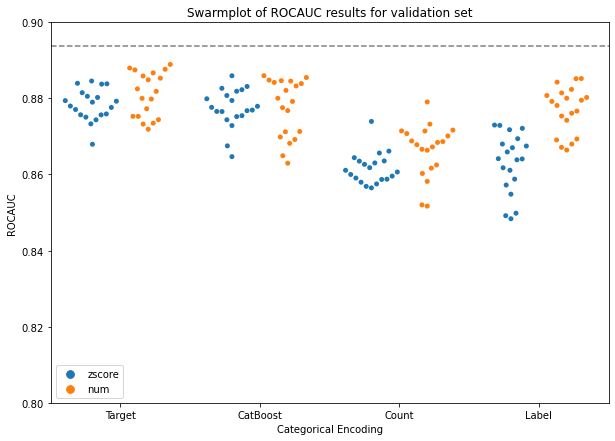

In [377]:
hue=np.array((['zscore']*20+['num']*20)*4)
x=np.array([0]*40+[1]*40+[2]*40+[3]*40)
Y=np.array([auc_scores[0][1].T,auc_encs[3],auc_scores[1][1].T,auc_encs[2],auc_scores[2][1].T,auc_encs[1],auc_scores[3][1].T,auc_encs[0]])
sns.swarmplot(x=x,y=Y.flatten().T,split=True,hue=hue)
plt.xticks([0,1,2,3],['Target','CatBoost','Count','Label'])
plt.axhline(y=0.893738,linestyle='dashed',color='grey')
plt.ylim(0.8,0.9)
plt.rcParams['figure.figsize']=(10,7)
plt.xlabel('Categorical Encoding')
plt.ylabel('ROCAUC')
plt.title('Swarmplot of ROCAUC results for validation set')

C:\Users\ritas\anaconda3\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Swarmplot of Recall results for validation set')

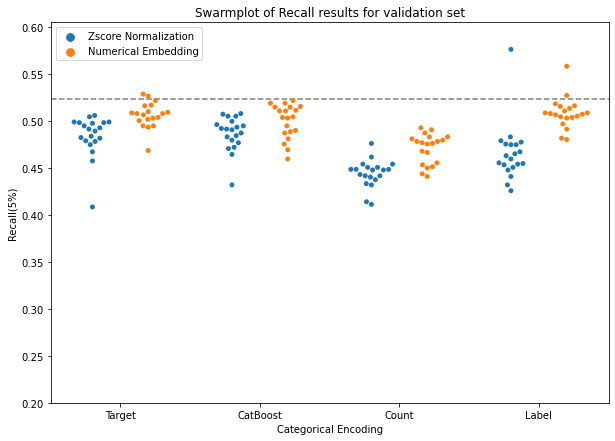

In [379]:
hue=np.array((['Zscore Normalization']*20+['Numerical Embedding']*20)*4)
x=np.array([0]*40+[1]*40+[2]*40+[3]*40)
Y=np.array([recall_scores[0][1].T,recall_encs[3],recall_scores[1][1].T,recall_encs[2],recall_scores[2][1].T,recall_encs[1],recall_scores[3][1].T,recall_encs[0]])
sns.swarmplot(x=x,y=Y.flatten().T,split=True,hue=hue)
plt.xticks([0,1,2,3],['Target','CatBoost','Count','Label'])
plt.axhline(y=0.52275,linestyle='dashed',color='grey')
plt.ylim(0.2)
plt.rcParams['figure.figsize']=(10,7)
plt.xlabel('Categorical Encoding')
plt.ylabel('Recall(5%)')
plt.title('Swarmplot of Recall results for validation set')

In [22]:
Y=np.array([recall_scores_test[0][0].T,recall_scores_test[0][1].T,recall_scores_test[0][2].T,recall_scores_test[0][3].T,recall_encs_test[3],
            recall_scores_test[1][0].T,recall_scores_test[1][1].T,recall_scores_test[1][2].T,recall_scores_test[1][3].T,recall_encs_test[2],
            recall_scores_test[2][0].T,recall_scores_test[2][1].T,recall_scores_test[2][2].T,recall_scores_test[2][3].T,recall_encs_test[1],
            recall_scores_test[3][0].T,recall_scores_test[3][1].T,recall_scores_test[3][2].T,recall_scores_test[3][3].T,recall_encs_test[0]])
x=np.array([0]*100+[1]*100+[2]*100+[3]*100)
hue=np.array((['No Normalization']*20+['Zscore Normalization']*20+['MinMax Normalization']*20+['Robust Normalization']*20+['Numerical Embedding']*20)*4)


C:\Users\ritas\anaconda3\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Swarmplot of Recall results for validation set')

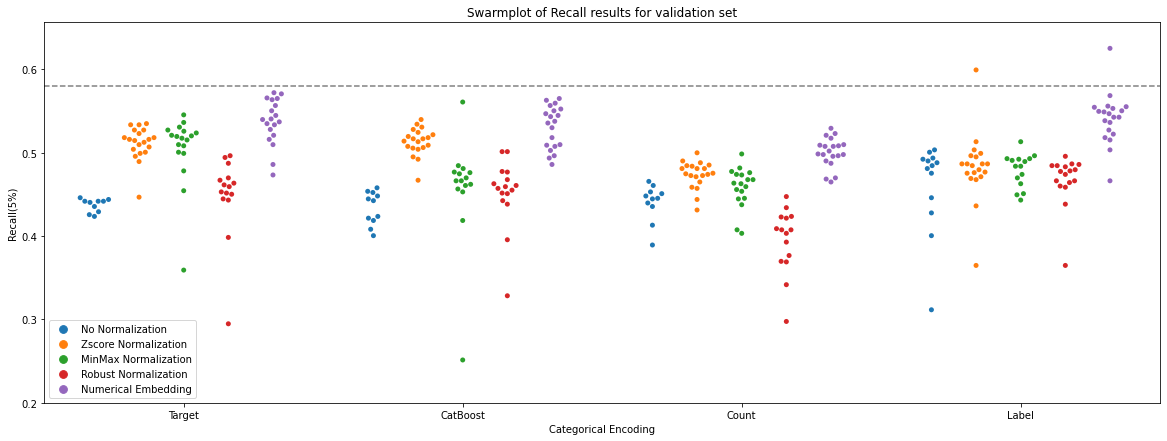

In [24]:
sns.swarmplot(x=x,y=Y.flatten().T,split=True,hue=hue)
plt.xticks([0,1,2,3],['Target','CatBoost','Count','Label'])
plt.axhline(y= 0.5798,linestyle='dashed',color='grey')
plt.ylim(0.2)
plt.rcParams['figure.figsize']=(20,7)
plt.xlabel('Categorical Encoding')
plt.ylabel('Recall(5%)')
plt.title('Swarmplot of Recall results for validation set')